### [Spreadsheet_url](https://docs.google.com/spreadsheets/d/1akdCIzVQ-IvVOju2L1VoTqAU37NMSQLA-kCM4LTPaWA/edit#gid=1681278835)

In [2]:
import pandas as pd 
import numpy as np
import requests
import gspread
import time
from PIL import Image 
import io
from bs4 import BeautifulSoup
import urllib.request 
import asyncio


auth_headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

gc = gspread.service_account("creds.json")

url = "https://docs.google.com/spreadsheets/d/1akdCIzVQ-IvVOju2L1VoTqAU37NMSQLA-kCM4LTPaWA/edit#gid=0"

spreadsheet = gc.open_by_url(url)


## Level 1 

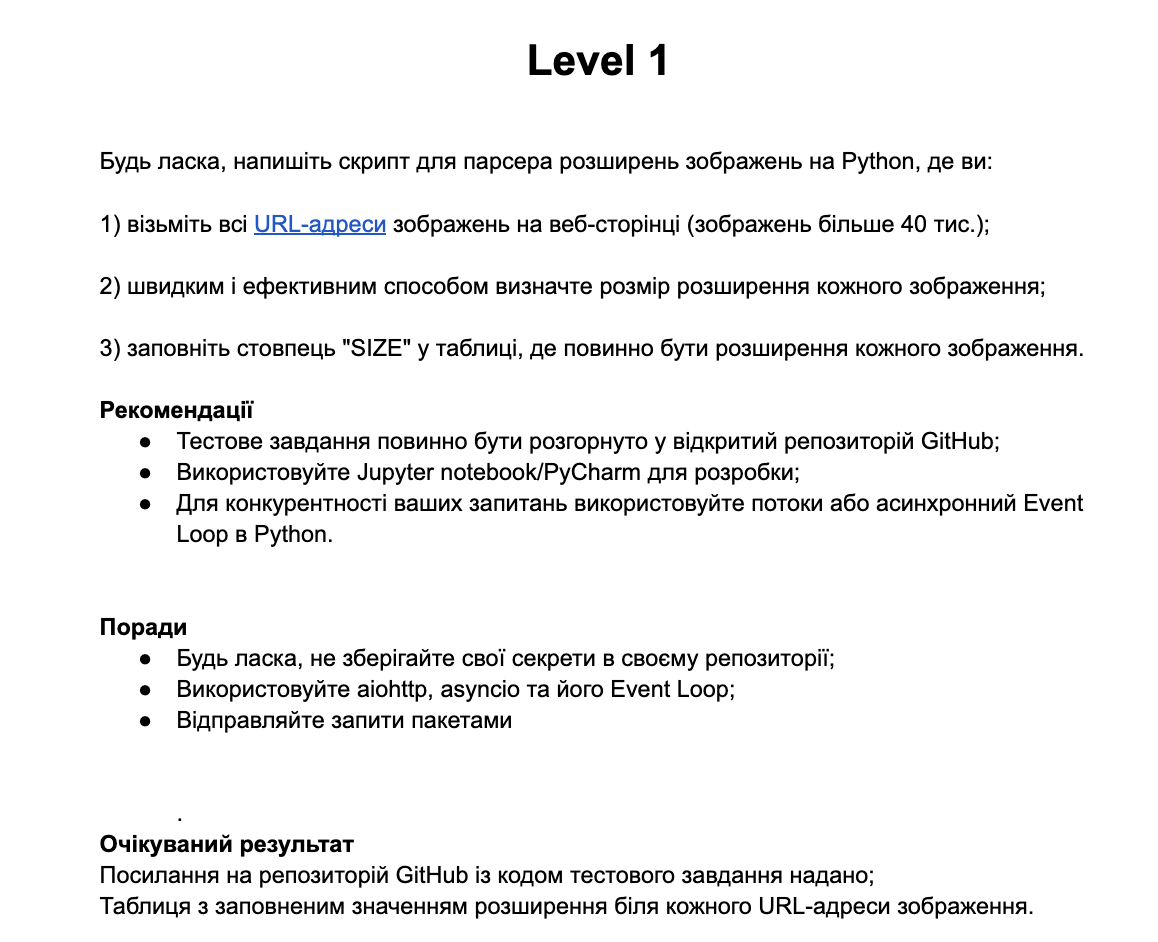

In [2]:
level_1 = spreadsheet.get_worksheet(0)
level_1_data = level_1.get_all_values()
headers = level_1_data.pop(0)

photo_urls = [list[0] for list in level_1_data]

Розвязуючи перше завдання, я помітив, що в кінці кожного посилання є додаткові параметри після "?", що відповідають якимось запитам для беку один з яких параметр "size", який є чуть не в кожному із сторінок.

Судячи зі всього цей параметр маштабує фотографію відносно розміру, який надалі вказаний. У випадку параметра size=feed-1080 - це мастшабуються до 1080

In [3]:
photo_url = 'https://data.sanitino.eu/PRODUCT-29343/4bedb8ffe2992120ad85586f?v=5bbf1116&size=feed-1080'

len('?size=feed-1080')

15

#### Test different links 

In [4]:
## with size parametr
req = urllib.request.Request(photo_url,headers=auth_headers)
image = Image.open(urllib.request.urlopen(req)) 
width, height = image.size 
print (width,height)

1093 1080


In [5]:
## without size parametr
data = requests.get(photo_url[:-15],headers = auth_headers)
data.content
im = Image.open(io.BytesIO(data.content))
im.size

(637, 630)

#### Main code

In [6]:
async def fix_url(url):
    return url.split('?')[0]
    
async def get_image_size(url:str,headers:dict[str,str]=auth_headers )->tuple[int,int]:
    #print("start_task")
    req = urllib.request.Request(url,headers=headers)
    try:
        req1 = urllib.request.urlopen(req)
        if req1.status ==200:
            image = Image.open(req1)
            return image.size
        return (-1*req1.status,-1*req1.status)
    except urllib.error.HTTPError as e :
        return (-1,-1)
    
async def main(urls):
    tasks = [get_image_size( await fix_url(url)) for url in urls]
    res = []
    for i in range(len(urls)):
        res.append(await tasks[i])
        if i%500 ==0:
            print(i)
    return res

    
    

Надалі я буду брати розмірі фотографій оригінальних фото:
для цього я буду брати фотографію без додаткових парамтетрів вказаних після ?

In [7]:
t1  = time.time()
k = await main(photo_urls[0:3000])
t2 = time.time()
print(f"Time run: {(t2-t1):.4f}")


0
500
1000
1500
2000
2500
Time run: 742.8721


#### Output

In [17]:
# print results to worksheet
def update_worksheet(sheet:gspread.worksheet.Worksheet,df = pd.core.frame.DataFrame,cell:str="A1")-> None:
    sheet.update(cell,[df.columns.values.tolist()] + df.values.tolist())
    
level_1_output = spreadsheet.get_worksheet(1)

df  = pd.DataFrame({"urls":photo_urls[0:3000],"SIZE":k})

df['SIZE'] = df['SIZE'].apply(lambda x: str(x).replace(',','*')[1:-1])


update_worksheet(level_1_output,df)

NameError: name 'photo_urls' is not defined

На мою думку, робити ще 15 запитів таких самих немає ніякого сенсу, адже в роботі скоріше за все це треба можна було поставити збирати на ніч і не моніторити це все 2 години підряд, тому я покажу лише 3000 даних

## Level 2 

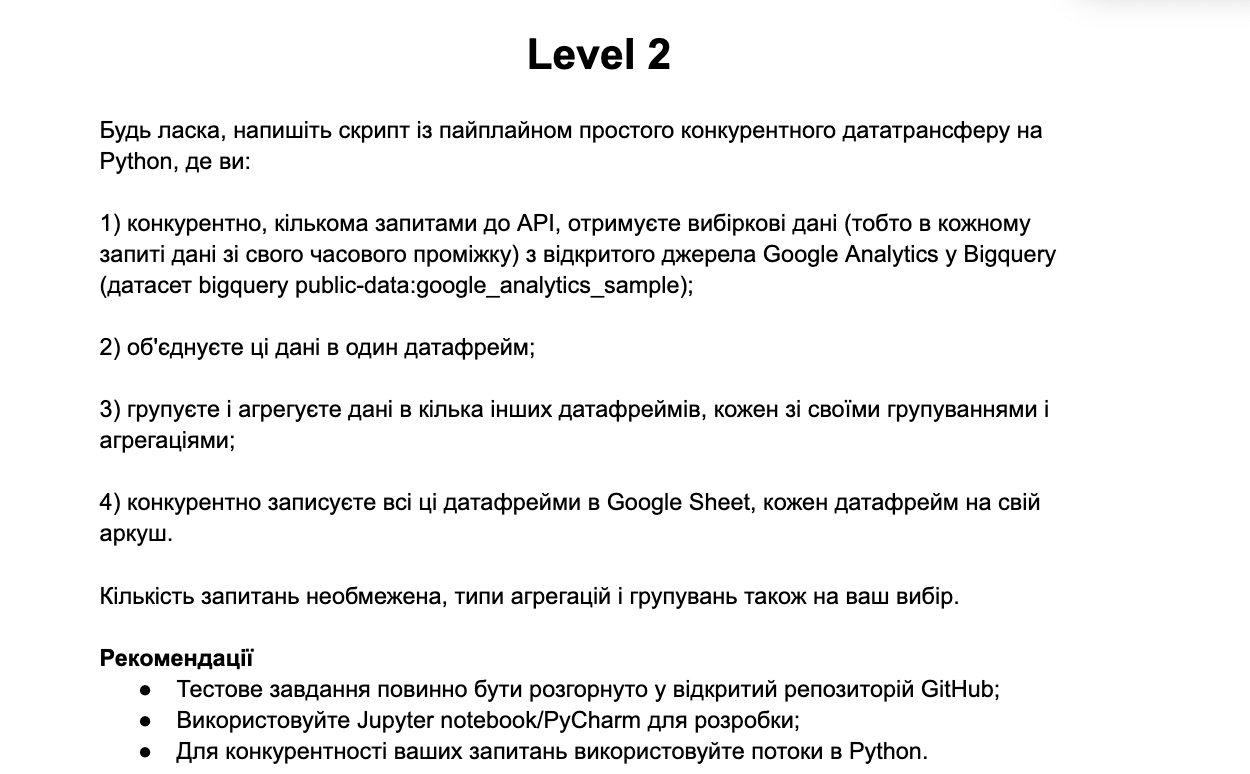

In [8]:
from google.cloud import bigquery
from datetime import datetime, timedelta

In [11]:
client = bigquery.Client.from_service_account_json("creds.json")

In [31]:
async def get_data(client:bigquery.client.Client,sql_query:str)->pd.core.frame.DataFrame:
    query_job = client.query(sql_query)
    results = query_job.result()
    df = pd.DataFrame(data=[list(row.values()) for row in results],
                      columns=[field.name for field in results.schema])
    return df

In [72]:
min_max_date = await get_data(client,"SELECT min(date),max(date) FROM bigquery-public-data.bls.cpi_u")
min_date = min_max_date['f0_'][0]
max_date = min_max_date['f1_'][0]
step = int((max_date-min_date).days/10)



def find_identical_periods(start_date:datetime.date, end_date:datetime.date, period:int)->list[datetime.date]:
    
    current_date = start_date
    identical_periods = [current_date]
    
    while current_date + timedelta(days=period) <= end_date:
        identical_periods.append(current_date + timedelta(days=period))
        current_date += timedelta(days=period)

    return identical_periods

periods = find_identical_periods(min_date,max_date,step)

In [79]:
sql_template = "SELECT * FROM `bigquery-public-data.bls.cpi_u` where date BETWEEN '{date_start}' and '{date_end}'"

In [100]:
tasks = []
for i in range(len(periods)-1):
    query = sql_template.format(date_start = str(periods[i]),date_end = str(periods[i+1]))
    tasks.append(get_data(client,query))

t1 = time.time()
dataframes = [await coroutine for coroutine in tasks]
t2 = time.time()
print(f"Time rum : {(t2-t1):4f}")

Time rum : 197.198903


In [117]:
# merge tables
df = pd.concat(dataframes,ignore_index=True)
df['date'] = pd.to_datetime(df['date'])

In [163]:
average_year_cpi_u = df[(df['area_name']=='U.S. city average')
&(df['item_name']=='All items')].groupby(by = 'year')\
.agg({'value':'sum'}).reset_index()

average_year_cpi_u.columns = ['Year','sum CPI']

In [172]:
pacific_df = df[(df['area_name']=='Pacific')&
(df['item_name'].isin(['Food','Commodities','Energy','Medical care']))]


pivot_pacific = pd.pivot_table(pacific_df,
               index='year',
               columns = 'item_name',
               aggfunc = ['sum'],
               values = 'value').reset_index()
pivot_pacific.columns = ['Year','Commodities','Energy','Food','Medical care']

In [201]:
max_by_year_alaska = df[df['area_name']=='Urban Alaska']\
.groupby(by = 'year')\
.agg({'value':'max'})\
.reset_index()


max_by_year_alaska.columns = ['Year','Max month CPI']
max_by_year_alaska['Max next month'] = max_by_year_alaska['Max month CPI'].shift(1)
max_by_year_alaska.fillna(388.2,inplace = True)
max_by_year_alaska['Increase percent'] = round(max_by_year_alaska['Max month CPI']/max_by_year_alaska['Max next month']*100-100,2)

In [ ]:
sh.add_worksheet(title="A worksheet", rows=100, cols=20)

In [205]:
max_by_year_alaska.shape

(25, 4)

In [206]:
average_year = spreadsheet.add_worksheet('Average year',rows = average_year_cpi_u.shape[0]+1, cols =average_year_cpi_u.shape[1]+1 )
pacific = spreadsheet.add_worksheet('Pacific pivot',rows = pivot_pacific.shape[0]+1,cols = pivot_pacific.shape[1]+1)
alaska = spreadsheet.add_worksheet('Alaska max month by year',rows = max_by_year_alaska.shape[0]+1,cols = max_by_year_alaska.shape[1]+2 )


In [209]:
update_worksheet(average_year,average_year_cpi_u)
update_worksheet(pacific,pivot_pacific)
update_worksheet(alaska,max_by_year_alaska)

/var/folders/m4/k4ccrm0s4s9f56wkhvdcmgc80000gp/T/ipykernel_65460/1165570684.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  sheet.update(cell,[df.columns.values.tolist()] + df.values.tolist())


## Level 3

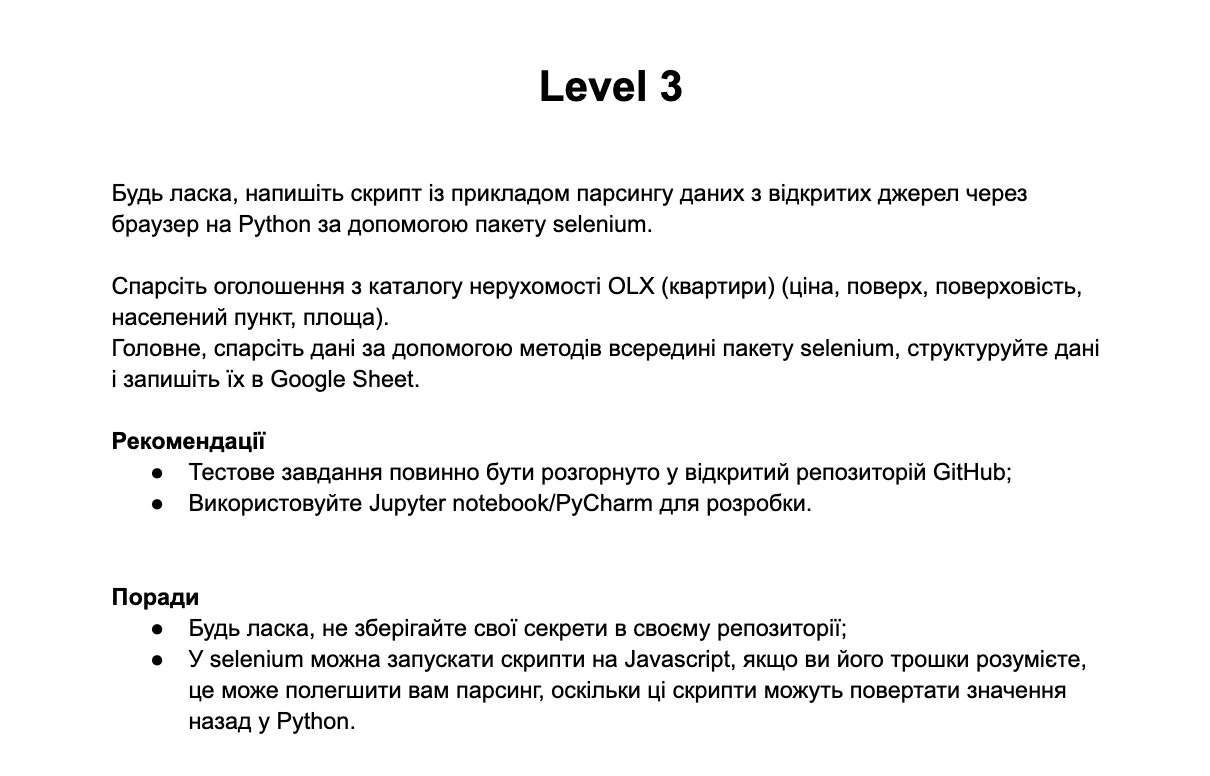

Для парсингу я вибрав сайт imdb зі своїми рейтигами

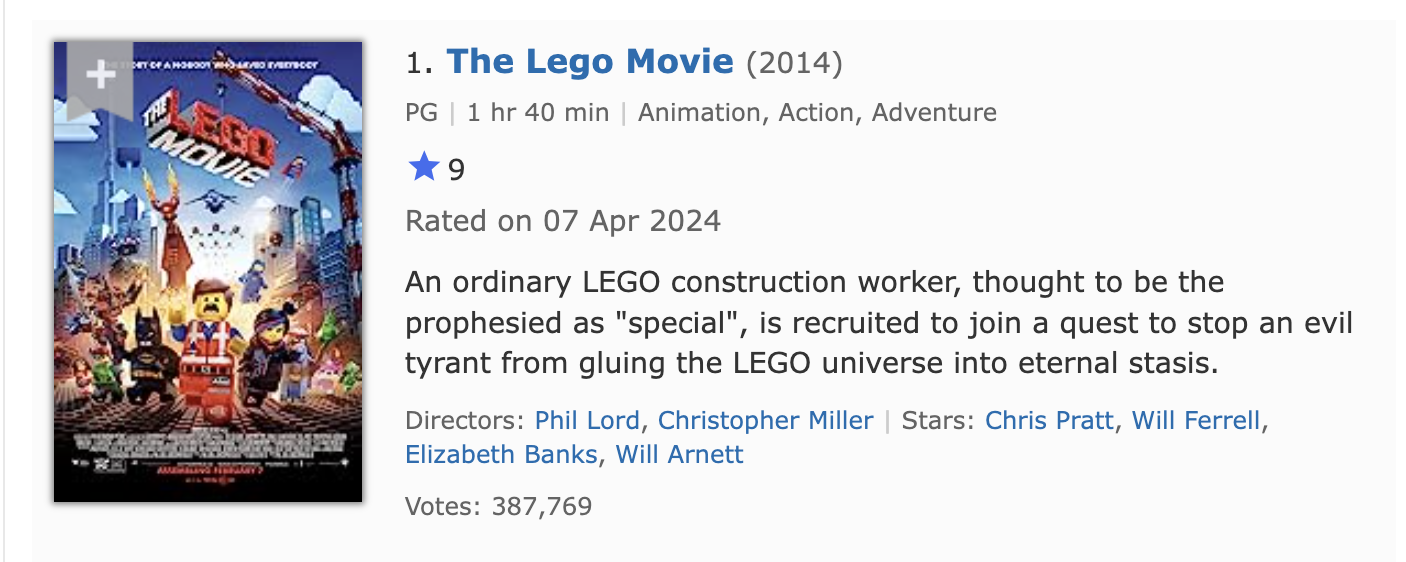

Я хотів взяти основну інформацію про фільм з сайту:
- назву
- рік випуску
- кількість голосів
- мою оцінку
- оцінку інших учасників( на фото не видно, її видно, якщо не мати аккаунта)

Можна було б далі парсити якісь дані та використати перехід на сторінку кожного і фільма і звідти витягувати акторів і тд, але я вирішив, що цього поки достатньо буде  

In [8]:
from selenium import webdriver
driver = webdriver.Chrome()
driver.get('https://www.imdb.com/user/ur153820349/ratings?ref_=nv_usr_rt_4')

from selenium.webdriver.common.by import By
titles = driver.find_elements(By.CLASS_NAME, "lister-item-header")
movie_objects = driver.find_elements(by = By.CLASS_NAME,value='lister-item-content')


def get_span_objects(span_elems:list[webdriver.remote.webelement.WebElement])->dict:
    dicti = {'year':'',
           'runtime':'',
           'genres':[],
           'imdb_rating':span_elems[9].text,
            'my_rating':span_elems[11].text,
            'votes':''}
    for el in span_elems:
        if el.get_attribute('class')=='lister-item-year text-muted unbold':
            dicti['year'] = el.text[1:-1]
        if el.get_attribute('class')=='runtime':
            dicti['runtime'] = el.text
        if el.get_attribute('class')=='genre':
            dicti['genres'] = el.text.split(',')
        if el.get_attribute('name')=='nv':
            dicti['votes'] = el.text
    return dicti
    

In [9]:
movies_desc = []
for title,movie_info in zip(titles,movie_objects):
    dict = get_span_objects(movie_info.find_elements(By.TAG_NAME,'span'))
    dict['title'] = title.text
    movies_desc.append(dict)

In [51]:
level_3_df = pd.DataFrame.from_records(movies_desc)
level_3_df['genres'] = level_3_df['genres'].apply(lambda x: ",".join(x))
level_3_df.head()

,year,runtime,genres,imdb_rating,my_rating,votes,title
0,2014,1 hr 40 min,"Animation, Action, Adventure",7.7,9,"387,770",1. The Lego Movie (2014)
1,2010 Video,1 hr 12 min,"Animation, Adventure, Comedy",7.2,7,"4,428",2. Scooby-Doo! Camp Scare (2010 Video)
2,2002,1 hr 26 min,"Adventure, Comedy, Family",5.3,6,"125,263",3. Scooby-Doo (2002)
3,I) (2015,2 hr 1 min,"Comedy, Drama",7.1,10,"273,612",4. The Intern (I) (2015)
4,2020,1 hr 43 min,"Animation, Action, Adventure",8,8,"38,509",5. Wolfwalkers (2020)


In [25]:
a =  spreadsheet.get_worksheet(5)

In [52]:
update_worksheet(a,level_3_df)

/var/folders/m4/k4ccrm0s4s9f56wkhvdcmgc80000gp/T/ipykernel_75031/574101325.py:2: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  sheet.update(cell,[df.columns.values.tolist()] + df.values.tolist())
